In [1]:
!pip install networkx

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


# Self study 4

In this self study we investigate some community detection (graph clustering) techniques.  We make extensive use of the Networkx package. The documentation can be found here: https://networkx.org/documentation/stable/reference/index.html

In [2]:
import numpy as np
import networkx as nx
import scipy as sp
import sklearn as skl
import itertools
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.quality import modularity

from sklearn.mixture import GaussianMixture

We are using a social network consisting of 71 lawyers. A description of the network and the original data can be found here:

https://www.stats.ox.ac.uk/~snijders/siena/Lazega_lawyers_data.htm

Of the three different relationships included in the data we will only be using the 'friendship' relation. This is a directed relationship, i.e., friends(a,b) does not necessarily imply friends(b,a) according to the data.

We load a version of the Lazega network data that only contains the 'friends' edges:

In [3]:
lazega=nx.readwrite.graphml.read_graphml('data.gml')

The nodes in the graph have the attributes "Practice" "Age" "Seniority" "Office" "Gender" "Status" . To obtain a dictionary with the values for a specified attribute for all nodes, we can use:

In [4]:
len(nx.get_node_attributes(lazega,'Office'))

69

The following is a little helper function that returns an array of attribute values of nodes according to the order in which nodes are returned by the G.nodes() function

In [5]:
def get_att_array(G,att_name):
    ret_array=np.zeros(nx.number_of_nodes(G))
    for i,n in enumerate(G.nodes()):
        ret_array[i]=G.nodes[n][att_name]
    return(ret_array)

We can use this to plot the graph using one of the layout algorithms provided by networkx, and nodes colored according to one of the attributes:

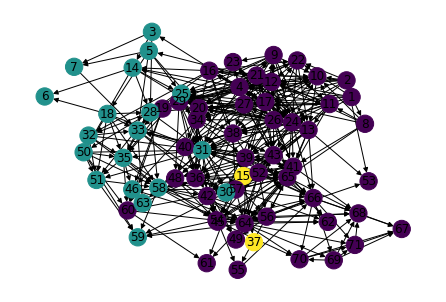

In [6]:
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=get_att_array(lazega,'Office'))

To make things a bit simpler, we turn the directed graph into an undirected one:

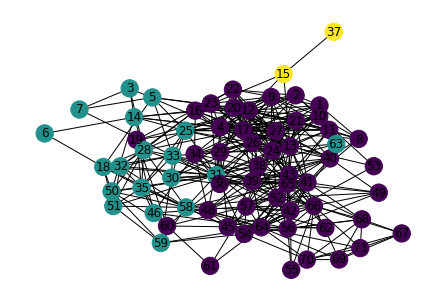

In [7]:
lazega=lazega.to_undirected()
nx.draw_kamada_kawai(lazega,with_labels=True,node_color=get_att_array(lazega,'Office'))

The networkx.algorithms.community.quality.modularity function can be used to measure the similarity score of a graph clustering. The clusters (communities) have to be provided as a list of lists of nodes. The following code provides the necessary transformations:

In [8]:
def get_modularity_and_community(attribute):
    att_array = get_att_array(lazega,attribute)
    att_dict= nx.get_node_attributes(lazega,attribute)
    att_communities = []
    for c in np.unique(att_array):
        comm_c =[]
        for n in lazega.nodes():
            if att_dict[n]==c:
                comm_c.append(n)
        att_communities.append(comm_c)  # communities divided via the attribute
    this_modularity = modularity(lazega, att_communities,)
    print("Modularity defined by attribute ''{}'': {}".format(attribute,this_modularity))
    return this_modularity, att_communities

**Task 1:** Use the networkx implementations of the Newman-Girvan algorithm to divide the Lazega network into 2,3,4,5 communities. Compare the communities returned by the algorithms with the communities defined by the attributes:
    
To what extend do the detected communities recover the attribute-defined communities? This is a case of what is called supervised cluster evaluation: a class label (or attribute) not used in the clustering process is assumed to represent a true underlying clustering, and we want our clustering method to recreate these underlying "ground truth" clusterings as much as possible (even though we cannot be sure that these "ground truth clusters" are indeed the most relevant clusters -- especially here, where we have multiple attributes that define competing "ground truths").
        
Compare the different community structures (attribute-based, and Newman-Girvan) according to their modularity scores.        
    
    

In [9]:
# this is a generator that calls next and divies executes a girvannewan algorithm on each step
dendrogram_iter = girvan_newman(lazega) 
#     print(a)
#     import time
#     time.sleep(1)
# results = []
names = ['2','3','4','5']
double = next(dendrogram_iter)
triple = next(dendrogram_iter)
quad = next(dendrogram_iter)
penta = next(dendrogram_iter)

models = [double, triple, quad, penta]

scores = []
print('The scores for different girvan newan iterations')
for m, name in zip(models, names):
    score = modularity(lazega,m)
    scores.append(score)
    print(f"{name}:{score}")

The scores for different girvan newan iterations
2:0.004934014233578955
3:0.00489004466052349
4:0.07145997826646822
5:0.07341034289985618


In [10]:
# Compute the modularity score for the existing attributes
attributes = ["Practice", "Age", "Seniority", "Office", "Gender", "Status"]
for i, attribute in enumerate(attributes):
    mod, community = get_modularity_and_community(attribute)

Modularity defined by attribute ''Practice'': 0.08067788518916338
Modularity defined by attribute ''Age'': -0.005926470311116134
Modularity defined by attribute ''Seniority'': 0.06420499871231965
Modularity defined by attribute ''Office'': 0.19672929190143276
Modularity defined by attribute ''Gender'': 0.07026023705881251
Modularity defined by attribute ''Status'': 0.25532502936539336


We now move on to the model-based community detection method. A "cheap" way to obtain embeddings of the nodes into 2-dimensional space is to use a graph layout algorithm. Networkx provides a few layout algorithms that return a dictionary of nodes:coordinates :

In [11]:
embedding=nx.kamada_kawai_layout(lazega)
train_data = np.array([])
for index, v in embedding.items():
    train_data = np.append(train_data,[int(index),*v])

train_data = train_data.reshape(69,3) 
#     train_data.append([int(index),*v])

**Task 2:** Calculate the log-likelihood of the lazega graph based on embeddings provided by different layout algorithms (cf. slide 31). Which layout provides the best "explanation" for the observed edges based on our probabilistic model?

Given coordinates for the nodes, we can now fit a Gaussian mixture model to these points. First we need to reshape our data again a little bit to fit the requirements of the next method in our pipeline: we turn the dictionary of positions into a standard array, where the first column contains the node identifier (not really needed in the following, but good to have it for possible checks along the road):

In [12]:
gmm=GaussianMixture(n_components=2,covariance_type='tied').fit(train_data)


Since we are doing clustering, we are using the 'predict' function of the learned mixture models on the training points:

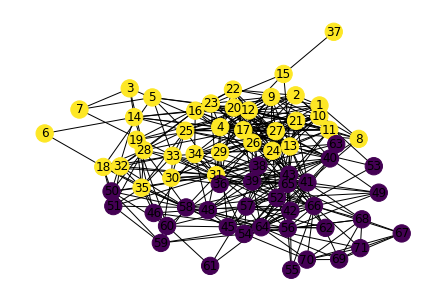

In [13]:
clusters=gmm.predict(train_data)

nx.draw(lazega,pos=embedding,with_labels=True,node_color=clusters)

![](aaloglike.png)


![](loglike.png)

## Some info
- **lambdas**: all the probabilities of gaussian mixtures
    - lambda: a scalar values representing a probability
- **means**: all the means of gaussian distribution
    - mean: 2 scalar values represting the geometrical mapping of the cluster
- **sigmas**: covariances of the gaussian distribution
    - sigma: 4 scalar values (just like always)

In [24]:
from scipy.stats import multivariate_normal

def log_likehood(gmm, k, data):
    # k is the number of clusters / same as number of mixture components
    lambdas, means, sigmas = gmm.weights_, gmm.means_, gmm.covariances_
  #  print(lambdas)  # probability of the Mixture distribution lambda
  # print(mus) # each of them is a cetnter of community/cluster
#     print(sigmas) # covariance

    res_i = 0
    for zi in data[:,1:3]:  # iterate over all latent points
        result_k = 0
        for j in range(k): # iterate over all of the clusters
            lambd = lambdas[j] # probability of this gaussian mixture/cluster
            cluster_mean = means[j] # 1 scalar
            cluster_covariance = sigmas[j] # 4 scalars
            result_k += lambd * multivariate_normal.pdf(zi, cluster_mean, cluster_covariance)  
        
        res_i += np.log(result_k)
    
    return res_i

def pr_log_for_layout(data, max_community_size = 6):
    for k in range(2, max_community_size):
        gmm=GaussianMixture(n_components=k,covariance_type='full',random_state=0).fit(data[:,1:3])
        print("k = {}: {}".format(k, log_likehood(gmm, k, data)))

pr_log_for_layout(train_data)

k = 2: -54.41197835814218
k = 3: -51.93947148794584
k = 4: -49.45844887214759
k = 5: -47.46667269845928


**Task 3:** Compare the modularity scores obtained by Gaussian mixture models with n_components = 2,3,4,5 and embeddings obtained from different layout methods. How does the modularity score relate to the likelihood scores computed in Task 2 -- do embeddings with higher likelihood score lead to clusterings with higher modularity? 

In [25]:
# We start by computing the log-likelihood of the mixture models estimated for a couple of embedding layout functions
layouts = {'kamada_kawai_layout': nx.kamada_kawai_layout, 'Circular': nx.circular_layout, 'Random': nx.random_layout,
           'Shell': nx.shell_layout, 'Spectral': nx.spectral_layout, 'Spring': nx.spring_layout}

# Compute log-likelihood for each layout
# for k in range(2, 6):
for name, layout in layouts.items():
    embedding = layout(lazega)
    pos_array = np.zeros((len(embedding),3))

    for i,k in enumerate(embedding.keys()):
        pos_array[i,0]=int(k)
        pos_array[i,1:3]=embedding[k]
    
    print(name)
    pr_log_for_layout(pos_array, max_community_size = 6)

kamada_kawai_layout
k = 2: -54.41197835814218
k = 3: -51.93947148794584
k = 4: -49.45844887214759
k = 5: -47.46667269845928
Circular
k = 2: -135.5621618319986
k = 3: -96.92875410632976
k = 4: -63.108913671412324
k = 5: -35.36038876321509
Random
k = 2: -18.456325982387032
k = 3: -8.948671809293172
k = 4: -2.4761556565190497
k = 5: 1.5163628724123352
Shell
k = 2: -135.5621614705649
k = 3: -96.92874942756366
k = 4: -63.23520563533715
k = 5: -35.04615560832925
Spectral
k = 2: 171.3054792038544
k = 3: 274.5804335383288
k = 4: 290.2518481052533
k = 5: 316.99877555456465
Spring
k = 2: -13.145106794610186
k = 3: -7.484389911183275
k = 4: -2.6390149228173687
k = 5: -0.9761413852567529


Using coordinates calculated by layout algorithms for our graph mixture model is of course not what one is supposed to do. The "proper" approach is to learn vectors z_i by maximizing the log-likelihood function. A full implementation of such an approach is outside the scope of what we can do in this self study. However, with relatively little effort we can take some steps in this direction. 

We make use of the fact that we already have a very special vector representation of the nodes in form of the rows of the adjacency matrix, which we can access as follows:


In [ ]:
am=nx.adjacency_matrix(lazega)
idx=2
print("The adjacency vector for node {} in a sparse vector representation is \n{}".format(list(lazega.nodes)[idx],am[idx,:]))
print("The same in a standard dense vector representation: \n{}".format(am[idx,:].todense()))

Using the dense vector representations, we can use the np.linalg.norm function to compute the Euclidean distance between two adjacency vectors:

In [ ]:
idx0=0
idx1=3
print("The distance between the adjacency vectors of nodes {} and {} is {}".format(list(lazega.nodes)[idx0],\
                                                                              list(lazega.nodes)[idx1],\
                                                                                  np.linalg.norm(am[idx0,:].todense()-am[idx1,:].todense())))

**Task 4:** Construct the 69x69 distance matrix between the nodes of the lazega graph based on the Euclidean distance between the adjacency vectors. Use this matrix and the multidimensional scaling implementation sklearn.manifold.MDS to construct 2-dimensional vector representations for the nodes. Fit again a Gaussian mixture model to these new representations, and compare the modularity score you get now to what you got in the earlier tasks. With this approach we are not limited to 2-dimensional vector representations: how do things change when you use multidimensional scaling with a target dimension of 3 or 4 instead?